<a href="https://colab.research.google.com/github/smraniaki/facialRecognition/blob/main/facialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install 'h5py<3.0.0'
%tensorflow_version 1.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import skimage.transform

     |████████████████████████████████| 2.9 MB 3.9 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
TensorFlow 1.x selected.


In [2]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.2 MB/s 


In [3]:
import mtcnn
mtcnn_model = mtcnn.MTCNN()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
facenet_model_path = '/content/drive/MyDrive/Machine_learning/keras_facenet/facenet_keras.h5'


In [6]:


facenet_model = tf.keras.models.load_model(facenet_model_path)

In [7]:
from google.colab.patches import cv2_imshow
import cv2

!curl -o pixney_faces.jpeg https://i.pinimg.com/originals/cf/04/14/cf0414f971aa50c87140ed49223da33b.jpg
disneypixarfaces = cv2.imread('pixney_faces.jpeg', cv2.IMREAD_UNCHANGED)




  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 64511  100 64511    0     0   139k      0 --:--:-- --:--:-- --:--:--  139k


In [8]:
#plt.imshow('pixney_faces.jpeg')

In [9]:
face_path = '/content/drive/MyDrive/Machine_learning/keras_facenet/faces/'
names_faces = {
    # name        :  face 
    'Ali Dolatabadi'   : 'AliDolatabadi.jpg',
    'Ali Nozari'  : 'AliNozari.jfif',
    'Fariba Haghbin'        : 'FaribaHaghbin.jfif',
    'Kourosh Pourang'        : 'KouPourang.jfif',
    'Reza Attarzadeh'         : 'RezaAttarzadeh.jpg',
    'Saieed Garmeh'         : 'SaGarmeh.jfif',
}
print(names_faces)

{'Ali Dolatabadi': 'AliDolatabadi.jpg', 'Ali Nozari': 'AliNozari.jfif', 'Fariba Haghbin': 'FaribaHaghbin.jfif', 'Kourosh Pourang': 'KouPourang.jfif', 'Reza Attarzadeh': 'RezaAttarzadeh.jpg', 'Saieed Garmeh': 'SaGarmeh.jfif'}



 Ali Dolatabadi


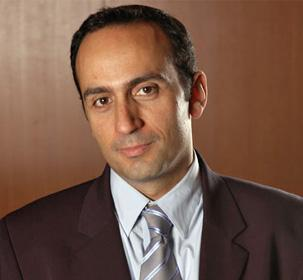


 Ali Nozari


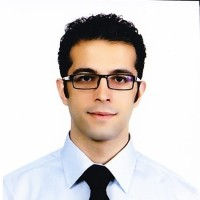


 Fariba Haghbin


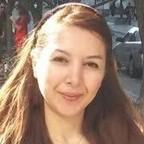


 Kourosh Pourang


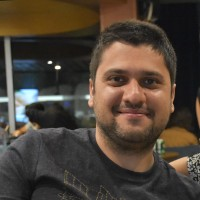


 Reza Attarzadeh


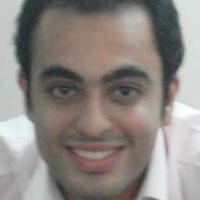


 Saieed Garmeh


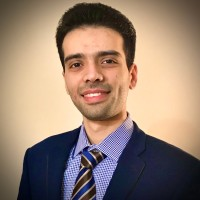

In [10]:
# show the images (these will be our ground truth)
for name, face in names_faces.items(): 
    # replace file names with actual images in the dictionary
    img = cv2.imread(face_path+face)
    # cv2 by default stores images in BGR format, store in RGB
    names_faces[name] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print('\n', name)
    cv2_imshow(img)

In [11]:
def whiten_image(img):
  img = img/255.0
  axis = (0, 1, 2)
  size = img.size
  mean = np.mean(img, axis=axis, keepdims=True)
  std = np.std(img, axis=axis, keepdims=True)
  std_adj = np.maximum(std, 1.0/np.sqrt(size))
  whitened_image = (img-mean)/std
  return whitened_image


In [12]:
from numpy.core.fromnumeric import size
size(whiten_image)
print(whiten_image)

<function whiten_image at 0x7fa29f2eb4d0>


In [13]:
def encode_face(img, x, y, w, h):
  #only the face part
  face_only = img[y:y+h, x:x+w, :]
  # resize to 160x160 (without stretching)
  face_only = skimage.transform.resize(face_only,(160, 160), mode='reflect')
  # normalize
  face_only = whiten_image(face_only)
  # find encoding
  encoding = facenet_model.predict(np.expand_dims(face_only, 0))
  return encoding


In [14]:
def encode_known_faces(face_dict):
    for name, face in face_dict.items():
        detected_faces = mtcnn_model.detect_faces(face)
        # extract details of the face
        for i in range(0, len(detected_faces)):
            x, y, w, h = detected_faces[i]['box']
            encoding = encode_face(face, x, y, w, h)
            # store it away
            face_dict[name] = encoding 
            #print(name, encoding)   
            break # assume only one face per image   

In [15]:
def find_closest_face(encoding):
  distances = []
  for name, face in names_faces.items():
    dist = np.linalg.norm(encoding-face)
    distances.append(dist)
  min_distance = np.min(distances)
  min_distance_name = list(names_faces)[np.argmin(distances)]
  return min_distance, min_distance_name

In [16]:
def recognize_faces(new_img):
  faces = mtcnn_model.detect_faces(new_img)
  for i in range(0, len(faces)):
      x, y, w, h = faces[i]['box']
      # compute encoding
      encoding = encode_face(new_img, x, y, w, h)
      # find the face with minimum encoding distance from this one
      dist, name = find_closest_face(encoding)
      if (dist < 11):
          print(dist, name)
          # draw rectangle and name
          cv2.rectangle(new_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
          cv2.putText(new_img, name, (x, y-3), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.75, (255, 0, 0), 2)
  return new_img


In [17]:
encode_known_faces(names_faces)

In [18]:
img = cv2.imread(face_path+'All.jpg')
print(face_path)



/content/drive/MyDrive/Machine_learning/keras_facenet/faces/


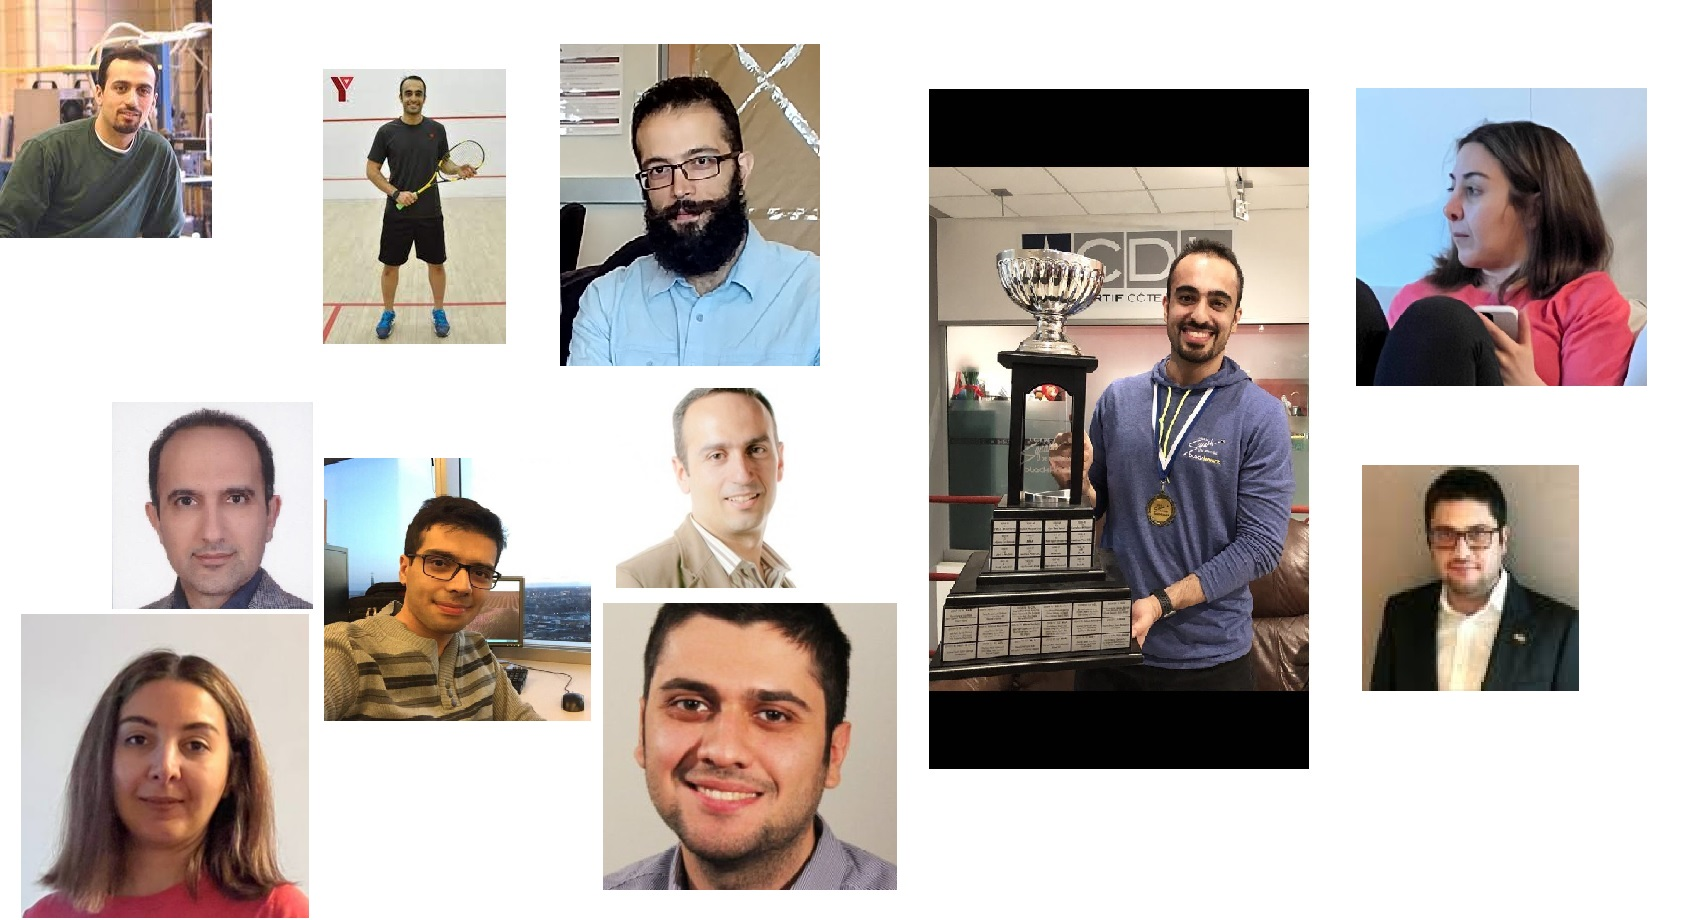

In [19]:
cv2_imshow(img)

In [20]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
final_img = recognize_faces(img)

8.248108 Kourosh Pourang
7.992373 Saieed Garmeh
7.2756076 Reza Attarzadeh
10.653415 Fariba Haghbin
9.231151 Ali Nozari
8.180056 Ali Dolatabadi


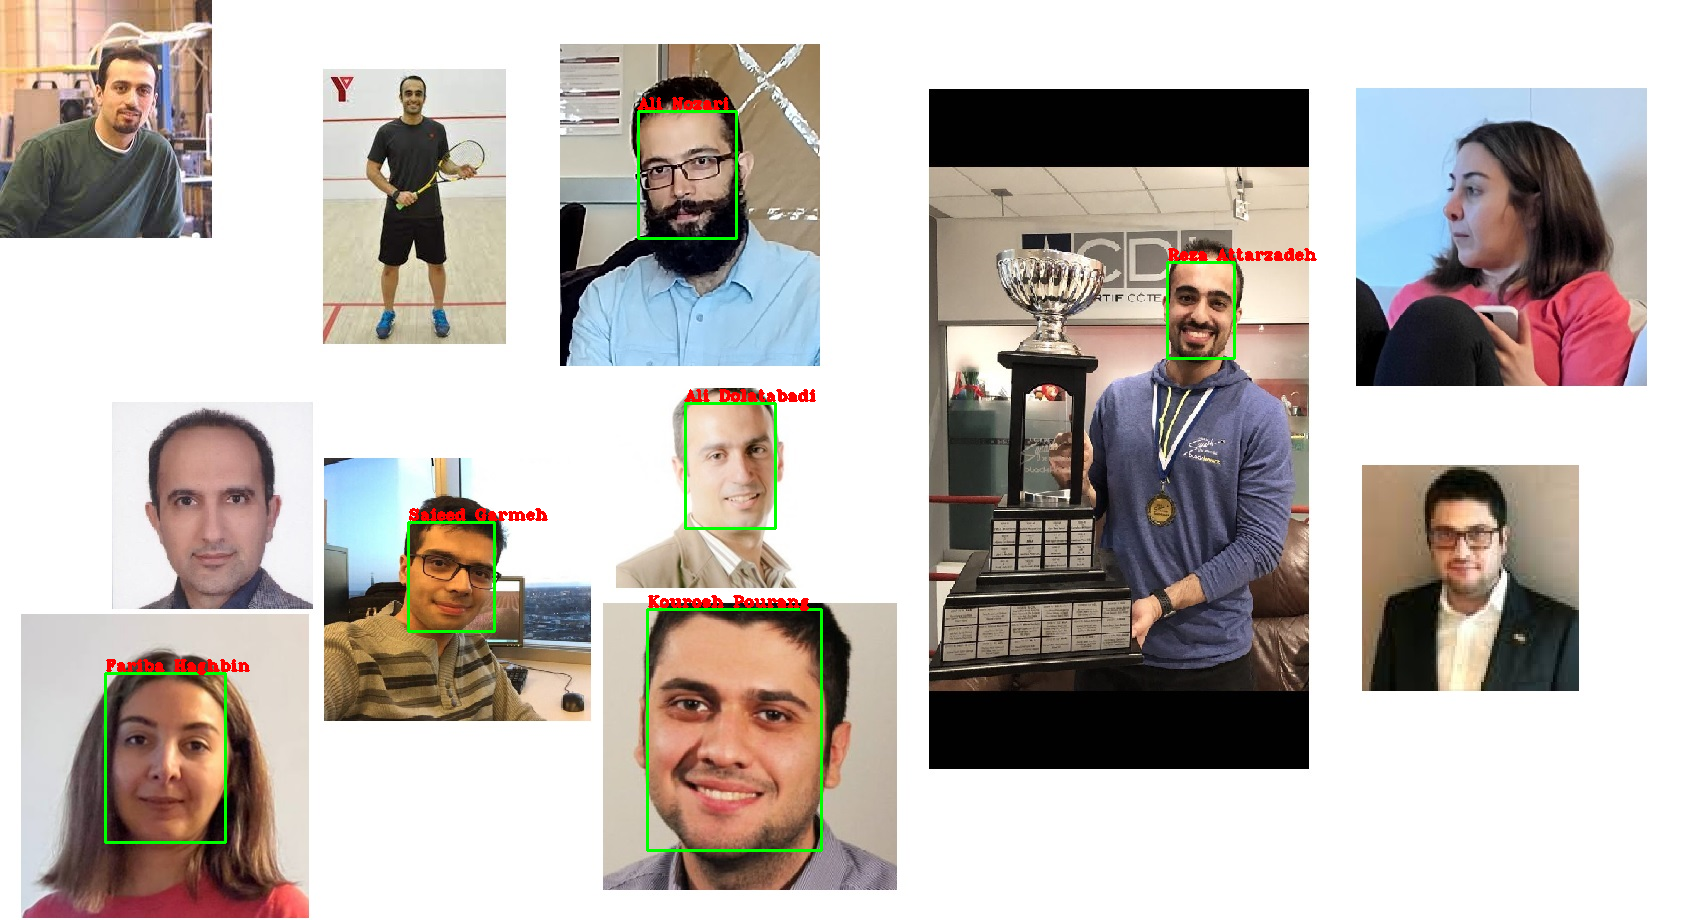

In [21]:
cv2_imshow(final_img[:,:,::-1])

In [22]:
'''
from IPython.display import HTML
from base64 import b64encode
mp4 = open('sample.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
'''

'\nfrom IPython.display import HTML\nfrom base64 import b64encode\nmp4 = open(\'sample.mp4\',\'rb\').read()\ndata_url = "data:video/mp4;base64," + b64encode(mp4).decode()\nHTML("""\n<video width=400 controls>\n      <source src="%s" type="video/mp4">\n</video>\n""" % data_url)\n'